In [84]:
import os
import cv2
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
from sklearn import svm
from skimage.feature import hog as skihog
from skimage.transform import resize
# from skimage.feature import SIFT as skiSIFT
from skimage import color
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier # using 1NN

# 1. Download the [cow teat datasets](https://github.com/YoushanZhang/SCTL) (10 points) resize image to (224, 224)

### (1). Create a train data loader that returns image arrays and labels
### (2). Create a test data loader that returns image arrays and file names
### (3). Print image arrays, labels and file names dimensions 

In [135]:
train_dir = r"SCTL\Train"
test_dir = r"SCTL\Test"
def get_train_images(folder):
    train_lbls = []
    train_imgs = []
    for lbl in os.listdir(folder):
        for imgf in os.listdir(os.path.join(folder, lbl)):
            train_lbls.append(int(lbl[-1])-1)
            img = plt.imread(os.path.join(folder, lbl, imgf)).copy()
            img = cv2.resize(img, (224, 224))
            train_imgs.append(img)
    return np.array(train_imgs), np.array(train_lbls)
    
        
def get_test_imgs(folder):
    test_f = glob(folder+"/*.jpg")
    test_imgs = []
    test_names = []
    for f in test_f:
        test_names.append(f.split("\\")[-1])
        img = plt.imread(f).copy()
        img = cv2.resize(img, (224, 224))
        test_imgs.append(img)
    return np.array(test_imgs), np.array(test_names)

train_imgs, lbls = get_train_images(train_dir)
test_imgs, test_fns = get_test_imgs(test_dir)

print(f"Train Images shape: {train_imgs.shape}, Train labels shape {lbls.shape}")
print(f"Test Images shape: {test_imgs.shape}, Test files shape {test_fns.shape}")

Train Images shape: (1149, 224, 224, 3), Train labels shape (1149,)
Test Images shape: (380, 224, 224, 3), Test files shape (380,)


Text(0.5, 1.0, 'Test Image, shape: (224, 224, 3)')

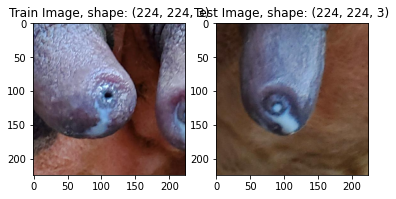

In [136]:
fig, axes = plt.subplots(1, 2)
axes[0].imshow(train_imgs[0])
axes[0].set_title(f"Train Image, shape: {train_imgs[0].shape}")
axes[1].imshow(test_imgs[0])
axes[1].set_title(f"Test Image, shape: {test_imgs[0].shape}")

# 2. Extract features of training and test images using HOG (20 points)
Please print the size of extracted features, e.g., training features: 1149 * d, test features: 380 *d

Single HOG feature shape (1568,)


array([0.36576587, 0.36576587, 0.36576587, ..., 0.2696949 , 0.38031035,
       0.30190334])

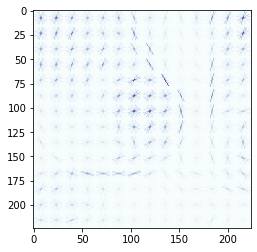

In [137]:
def HOG(img, display=False):
    f, hog_img = skihog(img, orientations=8, pixels_per_cell=(16, 16),
                         cells_per_block=(1, 1), visualize=True, multichannel=True)
    if display:
        plt.imshow(hog_img, cmap='BuPu')
    return f
hog_img = HOG(test_imgs[0])
# hog_img.reshape(224, 224)
print("Single HOG feature shape", hog_img.shape)
HOG(train_imgs[0], display=True)

In [138]:
hog_train = []
hog_test = [] 
for img in train_imgs:
    hog_train.append(HOG(img).flatten())
for img in test_imgs:
    hog_test.append(HOG(img).flatten())
hog_train = np.array(hog_train)
hog_test = np.array(hog_test)
print(f"Hog train shape {hog_train.shape}, test shape {hog_test.shape}")

Hog train shape (1149, 1568), test shape (380, 1568)


# 3. Extract features of training and test images using SIFT (20 points)
Please print the size of extracted features, e.g., training features: 1149 * d, test features: 380 *d

In [139]:
def SIFT(img):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sift = cv2.xfeatures2d.SIFT_create()
    kp, desc = sift.detectAndCompute(img, None)
    return desc
SIFT(train_imgs[0])

array([[ 0.,  1.,  2., ..., 16.,  4., 26.],
       [10.,  8.,  2., ...,  7., 10.,  3.],
       [ 0.,  0.,  0., ..., 22., 25., 40.],
       ...,
       [ 0.,  0.,  0., ...,  0.,  2.,  5.],
       [ 0.,  0.,  0., ...,  0.,  6.,  6.],
       [ 0.,  0., 77., ...,  0.,  0.,  0.]], dtype=float32)

SIFT is not able to identify features in some images i.e applyin rotation solves this problem.

In [140]:
def rotate_img_apply_sift(img):
    center = (img.shape[0]/2, img.shape[1]/2)
    # using cv2.getRotationMatrix2D() to get the rotation matrix
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=45, scale=1)
    # rotate the image using cv2.warpAffine
    img= cv2.warpAffine(src=img, M=rotate_matrix, dsize=(img.shape[0], img.shape[1]))
    return SIFT(img).flatten()[:64]

In [141]:
sift_train = []
sift_test = []

for idx, img in enumerate(train_imgs):
    sift_img = SIFT(img)
    if sift_img is not None:
        sift_train.append(sift_img.flatten()[:64])
    else:
        sift_train.append(rotate_img_apply_sift(img))
        
        
sift_test = []    
for idx, img in enumerate(test_imgs):
    sift_img = SIFT(img)
    if sift_img is not None:
        sift_test.append(sift_img.flatten()[:64])
    else:
        sift_test.append(rotate_img_apply_sift(img))
sift_train, sift_test = np.array(sift_train), np.array(sift_test)
print(f"Sift train shape {sift_train.shape}, Sift test shape {sift_test.shape}")

Sift train shape (1149, 64), Sift test shape (380, 64)


# 4. Extract features of training and test images using SURF (20 points)
Please print the size of extracted features, e.g., training features: 1149 * d, test features: 380 *d

In [142]:
def SURF(img):
    surf = cv2.xfeatures2d.SURF_create()
    kp, des = surf.detectAndCompute(img,None)
  # kp_image = cv2.drawKeypoints(img, kp, None, color=(0, 255, 0)
    return des

SURF(train_imgs[0]).flatten()

array([ 0.00032157, -0.00193003,  0.00449047, ...,  0.00386837,
        0.01093211,  0.00722594], dtype=float32)

In [143]:
surf_train = []
for img in train_imgs:
    surf_train.append(SURF(img).flatten()[:64])
    
surf_test = []    
for img in test_imgs:
    surf_test.append(SURF(img).flatten()[:64])


surf_train, surf_test = np.array(surf_train), np.array(surf_test)
print(f"Surf train shape {surf_train.shape}, Surf test shape {surf_test.shape}")

Surf train shape (1149, 64), Surf test shape (380, 64)


# 5. Call SVM and kNN from scikit-learn and train the extracted HOG, SIFT and SURF features, respectively, save three CSV files of test dataset using three features (10 points)

### (1) SVM and 5NN using HOG features

In [147]:
svc  = svm.SVC().fit(hog_train, lbls)
knn = KNeighborsClassifier(n_neighbors=1).fit(hog_train, lbls)


hog_svc_preds = svc.predict(hog_test)
print("HOG SVC predictions:", hog_svc_preds)
hog_knn_preds = knn.predict(hog_test)
print("HOG KNN predictions:", hog_knn_preds)

submission = pd.DataFrame({"Files": test_fns, "Preds": hog_svc_preds})
submission.to_csv("Haider HOG SVC submission.csv", index=False, header=None)


submission = pd.DataFrame({"Files": test_fns, "Preds": hog_knn_preds})
submission.to_csv("Haider HOG KNN submission.csv", index=False, header=None)

HOG SVC predictions: [0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0
 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 1 1 0 1 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0
 0 0 0 0 0 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 0 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 0 1 0 1 1]
HOG KNN predictions: [1 1 0 2 1 1 2 1 1 1 1 0 0 0 2 1 0 0 0 0 0 2 1 0 0 0 1 1 2 1 1 1 1 2 0 1 0
 1 1 1 1 0 1 0 0 1 1 1 0 0 2 2 1 0 2 0 0 1 2 1 2 1 1 0 1 0 1 1 1 1 1 0 1 0
 1 0 2 1 0 2 1 2 1 0 1 0 1 2 2 1 2 1

### (2) SVM and 5NN using SIFT features

In [148]:
svc  = svm.SVC().fit(sift_train, lbls)

knn = KNeighborsClassifier(n_neighbors=1).fit(sift_train, lbls)


sift_svc_preds = svc.predict(sift_test)
print("SIFT predictions:", sift_svc_preds)
sift_knn_preds = knn.predict(sift_test)
print("SIFT KNN predictions:", sift_knn_preds)


submission = pd.DataFrame({"Files": test_fns, "Preds": sift_svc_preds})
submission.to_csv("Haider SIFT SVC submission.csv", index=False, header=None)


submission = pd.DataFrame({"Files": test_fns, "Preds": sift_knn_preds})
submission.to_csv("Haider SIFT KNN submission.csv", index=False, header=None)

SIFT predictions: [0 0 1 0 0 0 1 1 0 1 1 0 0 0 1 1 0 1 0 0 1 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0
 1 1 0 1 0 0 1 1 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1
 0 0 1 0 1 1 0 1 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 0 0 1 0 1
 0 1 0 1 0 1 1 0 0 0 0 0 0 1 0 1 0 1 1 0 1 1 0 0 0 0 1 1 1 0 1 0 1 0 0 1 1
 1 0 0 0 0 0 1 0 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0
 1 0 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 0 1 1 1 0 1 0 0 1 1 0 0 1
 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 0 0 0 0 0 1
 1 0 0 0 0 1 1 0 1 0 1 1 0 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 1 0 0 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1
 1 1 1 1 1 0 1 1 1 0]
SIFT KNN predictions: [2 1 1 0 0 0 2 1 3 1 2 1 0 2 0 1 0 1 0 0 0 3 0 0 2 1 1 2 0 0 1 1 0 1 1 2 0
 1 1 0 1 1 1 0 0 0 1 2 0 0 0 1 1 0 0 0 0 1 0 0 0 1 3 0 1 0 0 0 0 0 2 2 0 0
 2 2 1 0 1 1 0 1 0 1 1 1 2 3 0 2 0 0 2

### (3) SVM and 5NN using SURF features

In [149]:
svc  = svm.SVC().fit(surf_train, lbls)
knn = KNeighborsClassifier(n_neighbors=1).fit(surf_train, lbls)


surf_svc_preds = svc.predict(surf_test)
print("SURF SVC predictions:", surf_svc_preds)
surf_knn_preds = knn.predict(surf_test)
print("SURF KNN predictions:", surf_knn_preds)


submission = pd.DataFrame({"Files": test_fns, "Preds": surf_svc_preds})
submission.to_csv("Haider SURF SVC submission.csv", index=False, header=None)
submission = pd.DataFrame({"Files": test_fns, "Preds": surf_knn_preds})
submission.to_csv("Haider SURF KNN submission.csv", index=False, header=None)

SURF SVC predictions: [0 1 0 1 1 1 1 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 1 0 0 0 1 0 0 1 0
 0 1 1 0 0 1 0 0 0 1 0 1 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 1 0 0 1 0 0 1 0 0
 0 0 0 0 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1
 1 1 1 0 1 0 1 1 0 1 1 0 0 1 0 1 1 0 0 0 0 1 0 1 1 1 0 1 0 1 0 0 0 0 1 0 0
 0 0 0 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 0 1 1 0 1 1 1 0 0 0 1 0 1 1 0 1 0 0 0
 0 0 0 0 1 1 0 1 0 1 0 1 0 1 1 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 1 1 1 1 0 1
 0 1 0 0 1 1 0 1 1 1 1 1 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 0 1 1 0
 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 0 0 1 1 1
 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 1 0 0 1 1
 0 1 0 1 1 1 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 1 0 0 1 1 1 1 0 1 1 1 0 0 1 1 1
 1 1 1 1 1 1 1 0 1 1]
SURF KNN predictions: [0 1 0 0 0 1 1 1 2 0 0 1 1 0 1 0 1 0 0 0 2 2 0 0 0 1 0 0 1 1 1 1 3 0 0 0 1
 1 0 0 0 0 1 0 1 0 1 0 2 1 1 0 1 2 2 0 1 0 1 2 1 0 0 0 1 0 1 0 1 0 1 1 0 1
 0 0 1 1 1 0 0 0 0 0 0 0 0 0 1 0 0

# 6. Report the accuracy using Cow_teat_classfication_accuracy software, please attach the results image here (20 points)

## HOG

### KNN

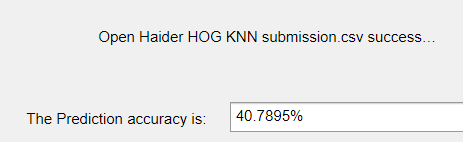
### SVC
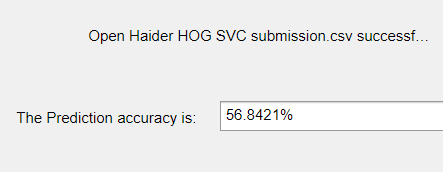

## SIFT

### KNN
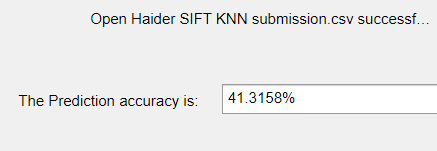

### SVC
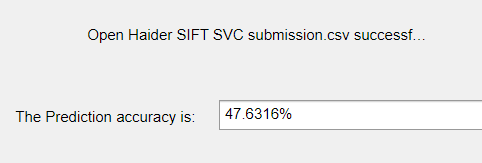


## SURF

### KNN
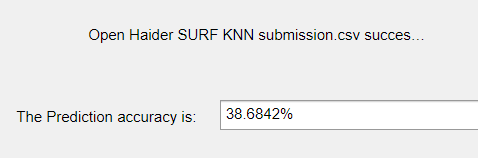
### SVC
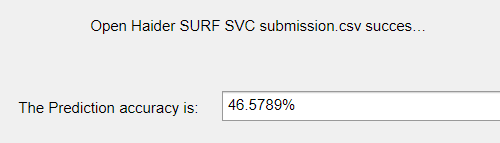